In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import os
import tensorflow as tf

train=pd.read_csv('/train.csv')



In [112]:
  train.date=train.date.str.replace('-','')
  train['date'] = pd.to_datetime(train['date'], format='%Y%m%d')
  train=train.rename(columns={'date':'ds'})

In [113]:
train_data=train.rename(columns = {'sales' : 'y'})
train_data.head()

,id,ds,store_nbr,family,y,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [114]:
# def rmsle(y_hat, y):
#     """Compute Root Mean Squared Logarithmic Error"""
#     metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
#                          - np.array(list(map(lambda x : np.log(x + 1), y))))**2)/len(y))
                
#     return round(metric, 4)

In [115]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [116]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)

        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()
        
    plt.xlabel('Days')

    
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size,
                                                      sequence_stride=1, shuffle=True, batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


def compile_and_fit(model, window, MAX_EPOCHS=20, learning_rate=0.2, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    
    return history

LSTM

In [117]:
# Parameters
start_training_ds = '2013-01-01'
input_width = 1*7
label_width = 16

MAX_EPOCHS = 50
learning_rate = 0.001
scaling = ['standardisation', 'normalisation'][0]

# Reshape the dataframe
df = train_data[train_data.ds >= start_training_ds].assign(key=train_data['store_nbr'].astype('str') + '~' + train_data['family'])
df = pd.pivot_table(df, values = 'y', index=['ds'], columns='key').reset_index()
date_time = df.ds
df = df.drop('ds', axis=1)
df = df.iloc[:, :df.shape[1]]
column_indices = {name: i for i, name in enumerate(df.columns)}

# Split into train, val and test set
n = len(df)
test_df = df[-label_width:]
val_df = df[-(input_width + 2*label_width):-label_width]
train_df = df[:-(input_width + label_width)]

print("Train set size: (%s, %s)" %(train_df.shape[0], train_df.shape[1]))
print("Validation set size: (%s, %s)"  %(test_df.shape[0], test_df.shape[1]))
print("Test set size: (%s, %s) \n"  %(val_df.shape[0], val_df.shape[1]))

num_features = df.shape[1]

# Perform normalisation
if scaling == 'standardisation':
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    train_df = train_df.fillna(0)
    val_df = (val_df - train_mean) / train_std
    val_df = val_df.fillna(0)
    test_df = (test_df - train_mean) / train_std
    test_df = test_df.fillna(0)

    train_df[train_df == np.inf] = 0
    val_df[val_df == np.inf] = 0
    test_df[test_df == np.inf] = 0

elif scaling == 'normalisation':
    scaler = MinMaxScaler(feature_range=(0,1))
    train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
    val_df = pd.DataFrame(scaler.transform(val_df), columns=val_df.columns)
    test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.make_dataset = make_dataset
WindowGenerator.split_window = split_window
WindowGenerator.plot = plot

# Generate windows for training batches
window = WindowGenerator(input_width=input_width, label_width=label_width, shift=label_width,
                         train_df=train_df, val_df=val_df, test_df=test_df)

model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.Conv1D(filters=128, kernel_size=(input_width,), activation='relu'),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(label_width*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([label_width, num_features])
])

print('Input shape:', window.example[0].shape)
print('Labels shape:', window.example[1].shape)
print('Output shape:', model(window.example[0]).shape)

history = compile_and_fit(model, window, MAX_EPOCHS, learning_rate)

Train set size: (1661, 1782)
Validation set size: (16, 1782)
Test set size: (23, 1782) 

Input shape: (32, 7, 1782)
Labels shape: (32, 16, 1782)
Output shape: (32, 16, 1782)
Epoch 1/50
52/52 [==============================] - 7s 83ms/step - loss: 0.7805 - mean_absolute_error: 0.5624 - val_loss: 1.2147 - val_mean_absolute_error: 0.6625
Epoch 2/50
52/52 [==============================] - 4s 68ms/step - loss: 0.6519 - mean_absolute_error: 0.4850 - val_loss: 1.1215 - val_mean_absolute_error: 0.6401
Epoch 3/50
52/52 [==============================] - 4s 69ms/step - loss: 0.6109 - mean_absolute_error: 0.4610 - val_loss: 1.0527 - val_mean_absolute_error: 0.6269
Epoch 4/50
52/52 [==============================] - 4s 68ms/step - loss: 0.5791 - mean_absolute_error: 0.4437 - val_loss: 0.9694 - val_mean_absolute_error: 0.5915
Epoch 5/50
52/52 [==============================] - 4s 68ms/step - loss: 0.5586 - mean_absolute_error: 0.4333 - val_loss: 0.9299 - val_mean_absolute_error: 0.5630
Epoch 6/50


In [118]:
y_hat = model.predict(val_df.values[-input_width:, :].reshape(1, input_width, num_features))
predict_df = (pd.DataFrame(y_hat.reshape(label_width, num_features), columns=df.columns)*train_std + train_mean).assign(ds=date_time[-label_width:].values)
columns_to_keep = [e for e in predict_df.columns if '~' in e or e == 'ds'] 
predict_df = predict_df[columns_to_keep]
predict_df = predict_df.melt(id_vars =['ds'], value_vars =[c for c in predict_df.columns if c != 'ds'])
predict_df[['store_nbr', 'family']] = predict_df.key.str.split('~', expand=True)
predict_df = predict_df.rename(columns={'value': 'y_hat'})
predict_df['store_nbr'] = predict_df.store_nbr.astype('int')
predict_df.drop('key', axis=1, inplace=True)

predict_df = pd.merge(train_data.drop('id', axis=1), predict_df, on=['ds', 'store_nbr', 'family'], how='left')
predict_df['y_hat'] = np.clip(predict_df.y_hat, 0, np.inf)

predict_df.tail()

,ds,store_nbr,family,y,onpromotion,y_hat
3000883,2017-08-15,9,POULTRY,438.133,0,361.059702
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,113.950329
3000885,2017-08-15,9,PRODUCE,2419.729,148,2129.245112
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,3.751567
3000887,2017-08-15,9,SEAFOOD,16.000,0,15.190373


In [119]:
import math
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_log_error

pred=predict_df[predict_df.ds>'2017-07-31']

rmsle = math.sqrt(mean_squared_log_error(pred.y,pred.y_hat))
mse = mean_squared_error(pred.y,pred.y_hat) 
rmse = math.sqrt(mean_squared_error(pred.y,pred.y_hat)) 
mae =  mean_absolute_error(pred.y,pred.y_hat) 


In [120]:
results={'mae':[mae], 'mse':[mse], 'rmse':[rmse], 'rmsle':[rmsle]}
pd.DataFrame(results)

,mae,mse,rmse,rmsle
0,94.947736,110786.211833,332.845628,0.615739


In [128]:
def rmsle(y_hat, y):

    metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
                         - np.array(list(map(lambda x : np.log(x + 1), y))))**2)/len(y))
                
    return round(metric, 4)

In [130]:
# the whole data trining and test

predict_df['error'] = (np.log(1 + predict_df[~predict_df.y_hat.isnull()].y) - np.log(1 + predict_df[~predict_df.y_hat.isnull()].y_hat))**2
print("RMSLE: %s" %rmsle(predict_df[~predict_df.y_hat.isnull()].y, predict_df[~predict_df.y_hat.isnull()].y_hat))

RMSLE: 0.6109


In [133]:
predict_df['key'] = predict_df['store_nbr'].astype(str) + '~' + predict_df['family'].astype(str)
rmsle_per_ts_df = predict_df.groupby('key').agg({'error': 'sum'}).sort_values('error', ascending=False).reset_index()
rmsle_per_ts_df.head(50)

,key,error
0,45~SCHOOL AND OFFICE SUPPLIES,243.906298
1,47~SCHOOL AND OFFICE SUPPLIES,242.975018
2,50~FROZEN FOODS,236.788867
3,46~SCHOOL AND OFFICE SUPPLIES,231.090171
4,48~FROZEN FOODS,229.751473
5,49~SCHOOL AND OFFICE SUPPLIES,217.619888
6,46~FROZEN FOODS,211.521645
7,50~SCHOOL AND OFFICE SUPPLIES,187.312825
8,48~SCHOOL AND OFFICE SUPPLIES,186.271384
9,9~SCHOOL AND OFFICE SUPPLIES,161.892077


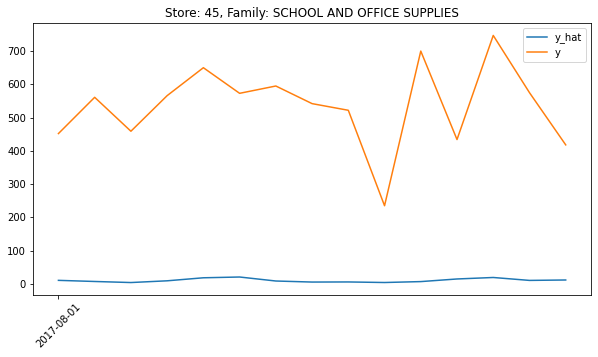

In [134]:

plot_ds_range = ['2017-08-01', predict_df.ds.iloc[-1]]
fig, ax = plt.subplots(figsize=(10, 5))
unique_keys = set(zip(train_data.store_nbr, train_data.family))
key = random.choice(list(unique_keys))
key = [45, 'SCHOOL AND OFFICE SUPPLIES']
ts = predict_df[(predict_df.store_nbr == key[0]) & (predict_df.family == key[1])]
ts = ts[(ts.ds >= plot_ds_range[0]) & (ts.ds <= plot_ds_range[1])]

# plt.plot(ts.ds, ts.onpromotion*np.median(ts.y), label='promotion')
plt.plot(ts.ds, ts.y_hat, label='y_hat')
plt.plot(ts.ds, ts.y, label='y')
plt.title("Store: " + str(key[0]) + ", Family: " + key[1])
plt.legend()
ax.set_xticks(np.array(ts.ds)[::100])
ax.tick_params(axis='x',rotation=45)
plt.show()

In [123]:
np.array((ts.y_hat)[-15:])

array([ 5.22194112,  4.94306999,  3.92056644,  6.07444718, 13.88896183,
       25.39457119,  5.72895386,  4.90405254,  4.84625441,  3.88037082,
        5.93813454, 12.40102347, 23.44462783,  4.89538118,  4.71547094])

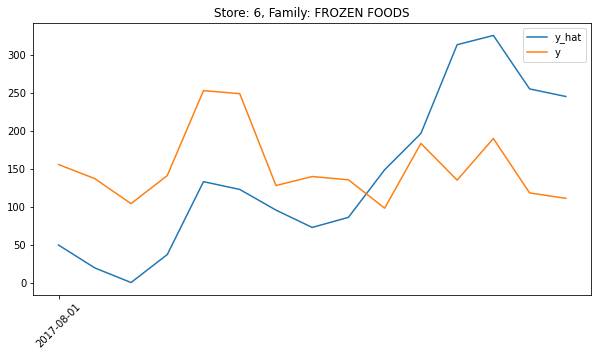

In [139]:
plot_ds_range = ['2017-08-01', predict_df.ds.iloc[-1]]
fig, ax = plt.subplots(figsize=(10, 5))
unique_keys = set(zip(train_data.store_nbr, train_data.family))
key = random.choice(list(unique_keys))
key = [6, 'FROZEN FOODS']
ts = predict_df[(predict_df.store_nbr == key[0]) & (predict_df.family == key[1])]
ts = ts[(ts.ds >= plot_ds_range[0]) & (ts.ds <= plot_ds_range[1])]

# plt.plot(ts.ds, ts.onpromotion*np.median(ts.y), label='promotion')
plt.plot(ts.ds, ts.y_hat, label='y_hat')
plt.plot(ts.ds, ts.y, label='y')
plt.title("Store: " + str(key[0]) + ", Family: " + key[1])
plt.legend()
ax.set_xticks(np.array(ts.ds)[::100])
ax.tick_params(axis='x',rotation=45)
plt.show()